## BEST Bayesian T-test

The **BEST (Bayesian Estimation Supersedes the t-Test)** approach offers a modern, more informative alternative to the traditional **t-test**. While the t-test provides a p-value to assess whether two group means are significantly different, it relies heavily on assumptions like:

- Normality of data
- Equal variances
- A fixed significance threshold (e.g., *p* < 0.05)

Moreover, the t-test doesn't convey the size or uncertainty of the effect in an intuitive way.

In contrast, **BEST** uses Bayesian methods to estimate the full **posterior distribution** of the group means and their difference. This approach provides a richer understanding, including:

- How large the difference might be
- How uncertain we are about that difference
- The probability that one group is greater than the other

BEST is also more robust to common issues like unequal variances and outliers.

In short, **BEST supersedes the t-test** by delivering **more nuanced, probabilistic insights** into group comparisons, rather than a single binary decision.

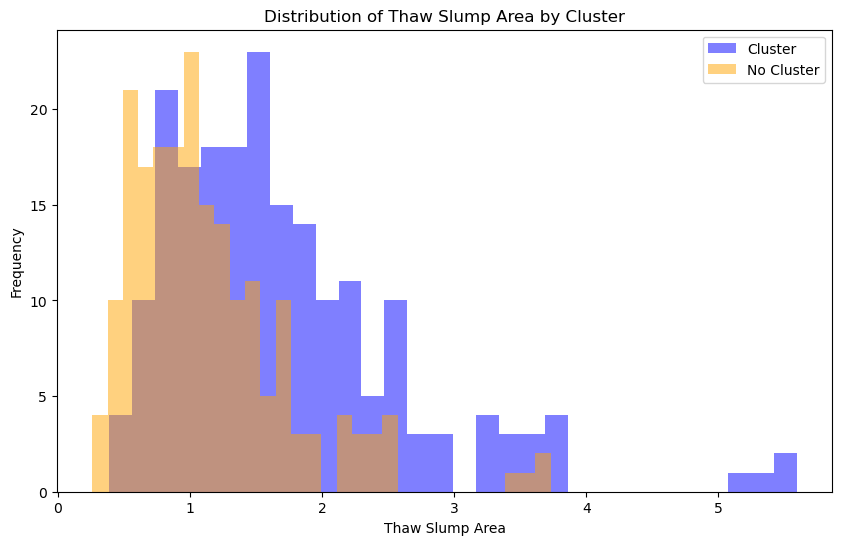

In [30]:
# first, lets create  some data. Here, we can think of 2 groups, cluster and no cluster and we want to see the difference in means for the Thaw Slump area within them.
# for simplicity, we will use a normal distribution for bot, but the ones in the cluster are 1.5 times larger than the ones outside the cluster.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# create the data
def create_data(n=200, ratio=1.5, sigma_ln=0.5):
    base = np.random.lognormal(mean=0, sigma=sigma_ln, size=n)
    cluster = base * ratio                 # larger but still skewed
    data = pd.DataFrame({
        "Thaw_Slump_Area": np.concatenate([cluster, base]),
        "Cluster": ["Cluster"]*n + ["No Cluster"]*n
    })
    return data

# lets call the function and visualize the data
data = create_data()
# visualize the data
plt.figure(figsize=(10, 6))
plt.hist(data[data['Cluster'] == 'Cluster']['Thaw_Slump_Area'], bins=30, alpha=0.5, label='Cluster', color='blue')
plt.hist(data[data['Cluster'] == 'No Cluster']['Thaw_Slump_Area'], bins=30, alpha=0.5, label='No Cluster', color='orange')
plt.title('Distribution of Thaw Slump Area by Cluster')
plt.xlabel('Thaw Slump Area')
plt.ylabel('Frequency')
plt.legend()

In [31]:
# next we will run a bayesian ttest to see if the means are significantly different. It will provide us with a bayesfactor and a credible interval. 
# To interpret the BF, we will use this function. This is for BF 10, expreces the evidence for supporting the alternative hypothesis over the null hypothesis.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pymc as pm
import arviz as az
from scipy.stats import gaussian_kde, norm
import ipywidgets as widgets
from IPython.display import display, clear_output

print("Running with PyMC version:", pm.__version__)


def interpret_bayes_factor(bf):
    """Return Jeffreys-style verbal label for a Bayes factor > 1."""
    if bf < 3:
        return "anecdotal"
    elif bf < 10:
        return "moderate"
    elif bf < 30:
        return "strong"
    elif bf < 100:
        return "very strong"
    else:
        return "extreme"
    
# next we define the ttest. Note that besed on your data, you might need to modify the prior and likelyhood functions.

def BEST(df, group_one, group_two, value_col, group_one_label='A', group_two_label='B', plot=True):

    """
    Perform Bayesian estimation of the difference in means and standard deviations
    between two groups using Student's t-distribution (Kruschke 2005).
    Args:
        combined_array (pd.DataFrame): DataFrame containing the metric values and group labels.
        group_one (np.ndarray): values of group 1.
        group_two (np.ndarray): values of group 2.
    Returns:
        None
    """

    values = df[value_col].values

    mu_m = values.mean()
    mu_s = values.std()*2

    sigma_low = 10**-1
    sigma_high = 10

    # define the model. change the priors as needed. 

    with pm.Model() as model:

        # Priors for group means (share common hyperpriors mu_m, mu_s)
        # We place Normal priors on each group’s mean, centered at a common location (mu_m) with shared uncertainty (mu_s) comming from the data (weakly informed).
        group1_mean = pm.Normal(f'{group_one_label}_mean', mu=mu_m, sigma=mu_s)
        group2_mean = pm.Normal(f'{group_two_label}_mean', mu=mu_m, sigma=mu_s)

        # Priors for group standard deviations (allowing unequal variances)
        # Each group’s scale is given an independent Uniform prior between sigma_low and sigma_high, allowing heterogeneity (previously defined --> uninformend as not from the data).
        group1_std = pm.Uniform(f'{group_one_label}_std', lower=sigma_low, upper=sigma_high)
        group2_std = pm.Uniform(f'{group_two_label}_std', lower=sigma_low, upper=sigma_high)

        # Degrees of freedom for Student-t (robust to outliers)
        #To model heavy tails and robustness to outliers, we use a Student-t likelihood. We put an Exponential prior on nu − 1, shift it to nu, and also expose its log₁₀ for diagnostics.
        nu_minus_one = pm.Exponential('nu_minus_one', lam=1/29)
        nu = pm.Deterministic('nu', nu_minus_one + 1)
        nu_log10 = pm.Deterministic('nu_log10', np.log10(nu))

        # Convert std to precision for the Student-t likelihood
        # Student-t in PyMC uses precision (λ = σ⁻²), so we square-invert the std priors.
        lambda_group1 = group1_std**-2
        lambda_group2 = group2_std**-2

        # Observation models for each group
        # Each group’s data are modeled as Student-t draws with their own mean, precision, and shared ν.
        group_one_obs = pm.StudentT(f'{group_one_label}_obs', mu=group1_mean, lam=lambda_group1, nu=nu, observed=group_one)
        group_two_obs = pm.StudentT(f'{group_two_label}_obs', mu=group2_mean, lam=lambda_group2, nu=nu, observed=group_two)

        # Deterministic comparisons for interpretation
        # We compute the difference of means, difference of stds, and Cohen’s d–style effect size for easy interpretation of the posterior.
        diff_of_means = pm.Deterministic('diff_of_means', group1_mean - group2_mean)
        diff_of_stds = pm.Deterministic('diff_of_stds', group1_std - group2_std)
        effect_size = pm.Deterministic('effect_size', diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2))

        # Posterior sampling
        idata = pm.sample(tune=1000, draws=2000, chains=4, target_accept=0.95, return_inferencedata=True)

    with model:                                                   # same model!
        prior_idata = pm.sample_prior_predictive(4000,
                                                    return_inferencedata=True)
    idata.extend(prior_idata)

    if plot:

        # Plotting the posterior distributions and summaries
        print('\n---- Posterior for the means and stds ----')

        az.plot_posterior(idata, var_names=[f'{group_one_label}_mean', f'{group_two_label}_mean', f'{group_one_label}_std', f'{group_two_label}_std', 'nu_log10', 'nu'])
        plt.show()

        print('\n---- Posterior for the differences and effect size ----')

        az.plot_posterior(idata, var_names=['diff_of_means', 'diff_of_stds', 'effect_size'], ref_val=0)
        plt.show()

        print('\n---- Forests for means, stds, and nu ----')
        
        az.plot_forest(idata, var_names=[f'{group_one_label}_mean', f'{group_two_label}_mean'])
        plt.show()

        print('\n---- Forests for stds and nu ----')

        az.plot_forest(idata, var_names=[f'{group_one_label}_std', f'{group_two_label}_std', 'nu'])
        plt.show()

        print('\n---- BayesFactor ----')
        az.plot_bf(idata, var_name=['diff_of_means'], ref_val=0)
        plt.show()


    print('\n---- Model summary ----')

    summary = az.summary(idata, var_names=[f'{group_one_label}_mean', f'{group_two_label}_mean','diff_of_means', 'diff_of_stds', 'effect_size'])
    print(summary)

    print('\n---- Bayes Factor ----\n')

    bf_dict = az.bayes_factor(
        idata,
        var_name="diff_of_means",   # name of the deterministic
        ref_val=0                   # H0 : μ₁ − μ₂ = 0
    )

    BF_10 = bf_dict["BF10"]
    BF_01 = bf_dict["BF01"]

    if BF_10 > 1:

        winner, loser = group_two_label, group_one_label

        label = interpret_bayes_factor(BF_10)
        print(f"Evidence for {winner} outperforming {loser}: "
              f"BF₁₀ = {BF_10:.4g}  ({label})\n")

    else:
        label = interpret_bayes_factor(BF_01)
        print(f"Evidence for no difference (H₀): "
              f"BF₀₁ = {BF_01:.4g}  ({label})")

Running with PyMC version: 5.22.0


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Cluster_mean, No Cluster_mean, Cluster_std, No Cluster_std, nu_minus_one]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 36 seconds.
Sampling: [Cluster_mean, Cluster_obs, Cluster_std, No Cluster_mean, No Cluster_obs, No Cluster_std, nu_minus_one]



---- Posterior for the means and stds ----


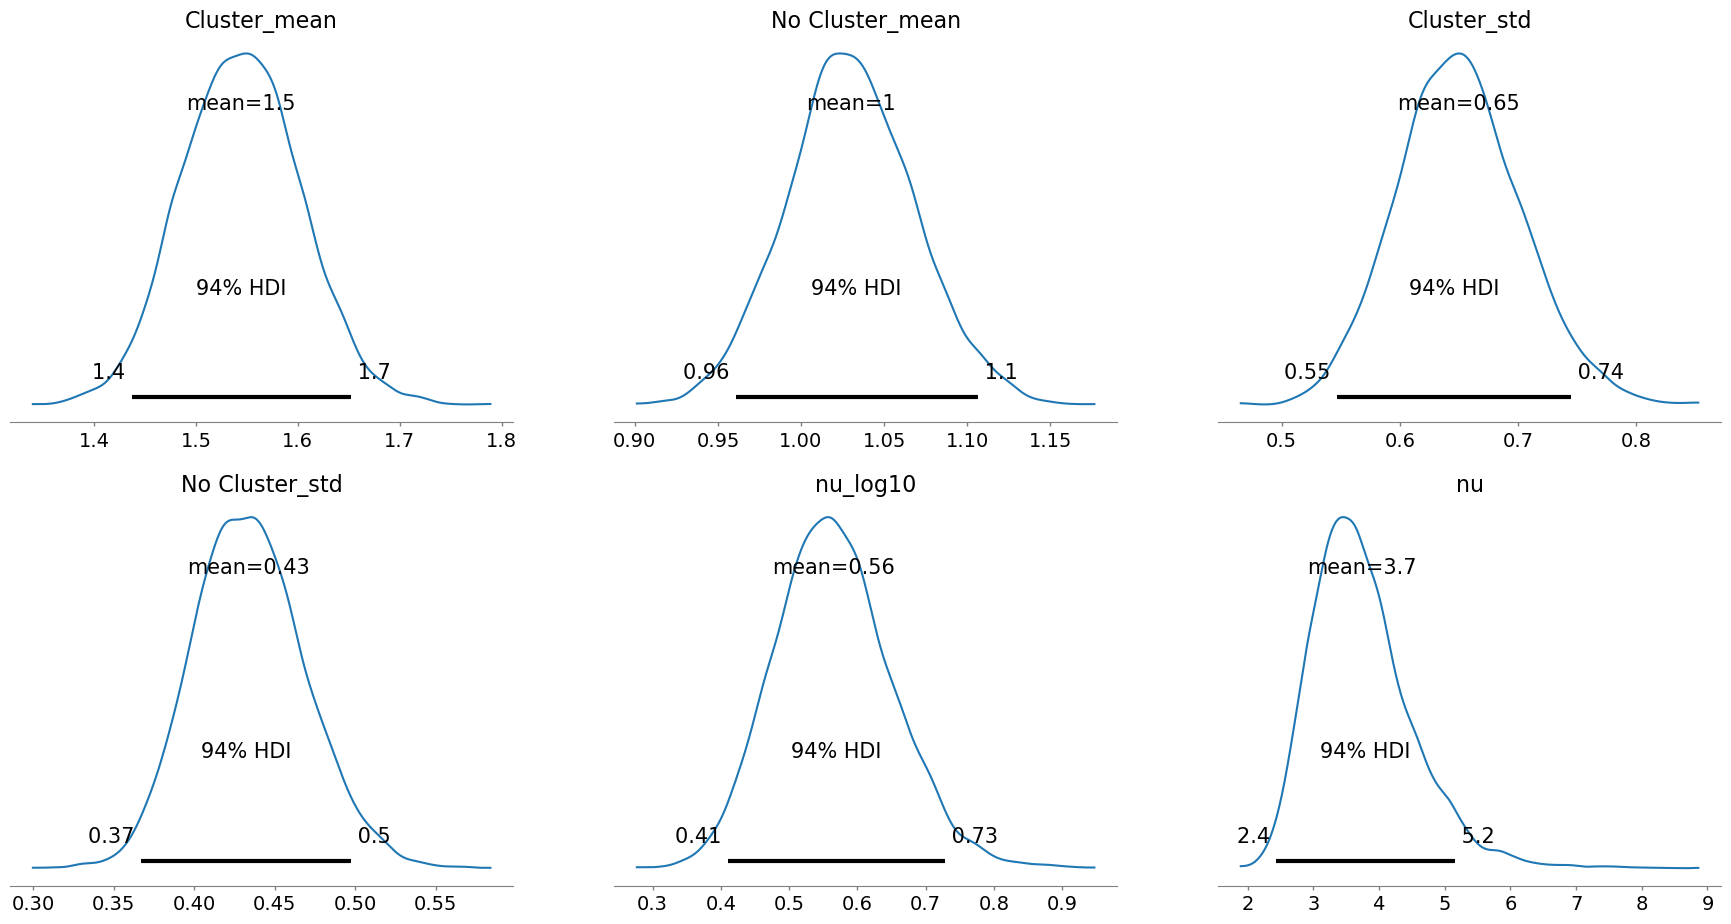


---- Posterior for the differences and effect size ----


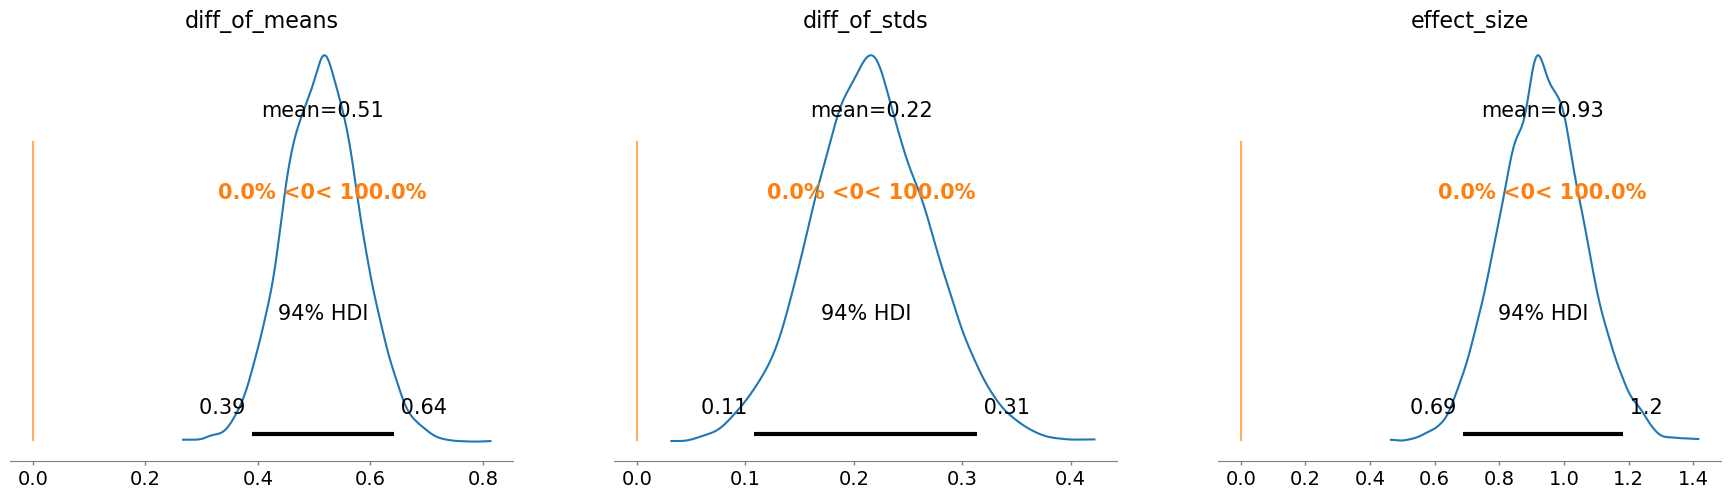


---- Forests for means, stds, and nu ----


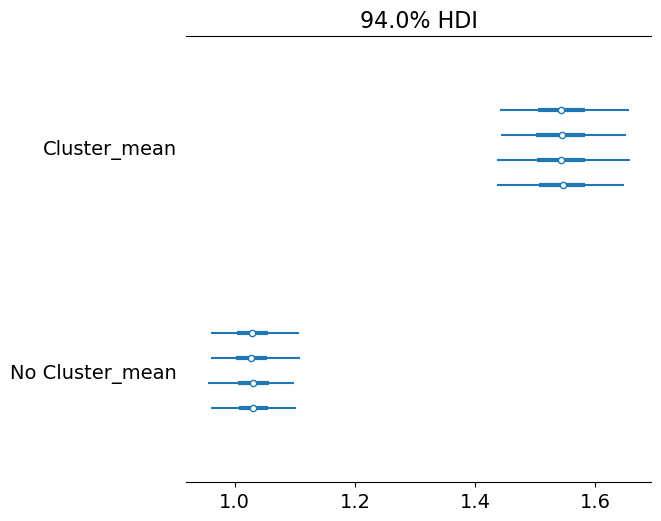


---- Forests for stds and nu ----


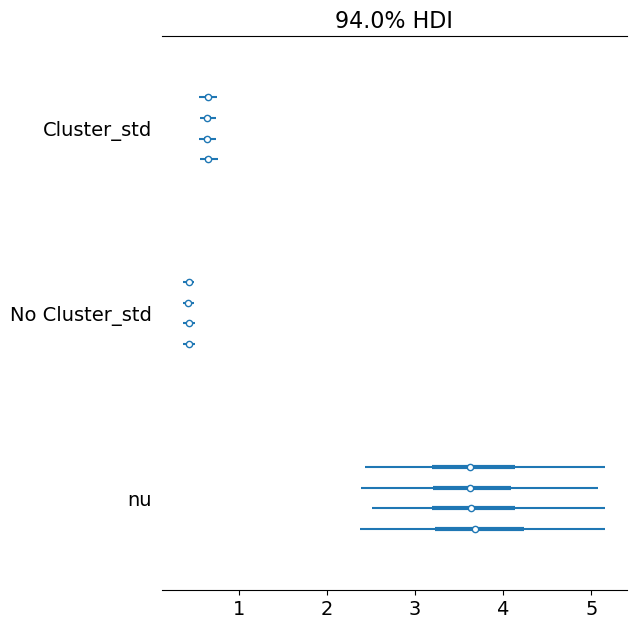


---- BayesFactor ----


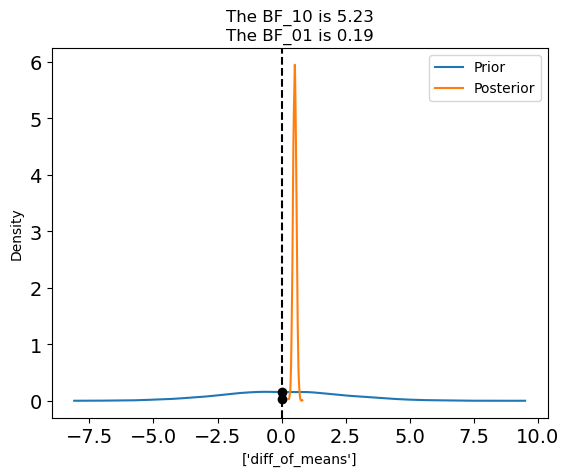

arviz - WARNING - The reference value is outside of the posterior. This translate into infinite support for H1, which is most likely an overstatement.



---- Model summary ----
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Cluster_mean     1.544  0.058   1.437    1.652      0.001    0.001    7263.0   
No Cluster_mean  1.030  0.038   0.961    1.106      0.000    0.000    6712.0   
diff_of_means    0.514  0.067   0.390    0.642      0.001    0.001    8111.0   
diff_of_stds     0.216  0.054   0.108    0.314      0.001    0.001    9471.0   
effect_size      0.933  0.131   0.689    1.184      0.001    0.001    7953.0   

                 ess_tail  r_hat  
Cluster_mean       5601.0    1.0  
No Cluster_mean    5431.0    1.0  
diff_of_means      5649.0    1.0  
diff_of_stds       5693.0    1.0  
effect_size        5957.0    1.0  

---- Bayes Factor ----

Evidence for No Cluster outperforming Cluster: BF₁₀ = 5.233  (moderate)



In [32]:
# lets run the ttest
group_one = data[data['Cluster'] == 'Cluster']['Thaw_Slump_Area'].values
group_two = data[data['Cluster'] == 'No Cluster']['Thaw_Slump_Area'].values

BEST(data, group_one, group_two, value_col='Thaw_Slump_Area', group_one_label='Cluster', group_two_label='No Cluster', plot=True)